# Michelin survivor
Michelin-rated restaurants are some of the highest-grossing businesses in the fine-dining industry – a $10 billion market in the U.S. Inversely, losing a Michelin star can make a business less profitable, with up to 40% of these businesses closing within 5 years. At Insight, I used Yelp reviews to develop a product that forecasts the risk of a restaurant losing a Michelin star and provides actionable insights to restaurateurs and investors on how to improve if their business is deemed at risk. Restaurants have vastly different timelines - from opening, getting Michelin-rated, to closing shop - so wrangling 100k Yelp reviews into usable time-series was a significant challenge to overcome, and vital in broader risk assessment and survival analysis problems.

In [52]:
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd


michelin_data    = pd.read_csv('michelin_nyc_stars.csv')
michelin_data    = michelin_data.iloc[:,1:]
michelin_data    = michelin_data.drop_duplicates(keep = False)
michelin_data

,name,stars_2007,stars_2008,stars_2009,stars_2010,stars_2011,stars_2012,stars_2013,stars_2014,stars_2015,stars_2016,stars_2017,stars_2018,stars_2019
0,15-east,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,a-voce,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,a-voce-columbus,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,adour,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,agern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
5,ai-fiori,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,aldea,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,allen-and-delancey,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,alto,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,amy-ruths,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data preprocessing and helper functions

In [27]:
# %load helper_functions.py
import numpy as np
from scipy.stats import linregress, kurtosis, skew
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from sklearn import preprocessing
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize




def get_review_topic_weights(yelp_data):

    yelp_data['review'] = (yelp_data.review.str.replace('\\\\xc2', '')
                       .str.replace('\\\\xa0', '')
                        .str.replace('\\\xa0', '')
                       .str.lower()
                       .str.replace('\d+', '')
                       .str.replace(r'[^\w\s]+', '')
                        .str.replace('cocktails', 'cocktail')
                        .str.replace('zzs', '')
                        .str.replace('xc', '')
                        .str.replace('xa', '')
                        .str.replace('zz', '')
                        .str.replace('       ', '')
                        .str.replace('eellent', 'excellent')
                        .str.replace(r'\bthe\b', '')
                        .str.replace(r'\band\b', '')
                        .str.replace(r'\bas\b', '')
                        .str.replace(r'\bof\b', '') )
    
    yelp_data['restaurant'] = (yelp_data['restaurant'].str.replace('é', 'e').str.replace('ë', 'e'))
                       


    # yelp_data.date   =  yelp_data.date.str.replace('Updatedreview', '')                  )
    yelp_data['date']  = pd.to_datetime(yelp_data.date.str.replace('Updatedreview', ''))
    yelp_data        = yelp_data.drop_duplicates(keep = False)

    pos_reviews = yelp_data.review[(yelp_data.rating>3)].values
    neg_reviews = yelp_data.review[(yelp_data.rating<=3)].str.replace('\\\xa0', '').values


    extra_words = ['ve', 'like', 'got', 'just',
                   'don', 'really', 'said', 'told', 'ok',
                   'came', 'went', 'did', 'didn', 'good']

    stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)
    tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5,
                            ngram_range=(1,1), token_pattern='[a-z][a-z]+')

    tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5,
                            ngram_range=(1,1), token_pattern='[a-z][a-z]+')

    dicty = {'noodles' : 'noodle', 'dishes': 'dish',
             'buns': 'bun', 'asked' : 'ask',
             'pieces' :'piece', 'burgers' : 'burger' ,
            'minutes' : 'minute', 'orders' : 'order', 'waffles' :'waffle'}

    def replace_words(text, dicty):
        for i,j in dicty.items():
            text = text.replace(i,j)
        return text

    neg   = [replace_words(w, dicty) for w in neg_reviews]
    pos   = [replace_words(w, dicty) for w in pos_reviews]


    neg_vectors   = tfidf_neg.fit_transform(neg)
    pos_vectors   = tfidf_pos.fit_transform(pos)

    num_topics = 10

    nmf_pos = NMF(n_components=num_topics)
    W_pos = nmf_pos.fit_transform(pos_vectors)
    H_pos = nmf_pos.components_

    nmf_neg = NMF(n_components=num_topics)
    W_neg = nmf_neg.fit_transform(neg_vectors)
    H_neg = nmf_neg.components_


    pos_topics = {0:'great offerings', 1:'fresh ingredients', 2:'feel-good food',
                      3:'great pub food', 4:'great ambiance', 5: 'authentic food',
                      6: 'great value', 7: 'impressive dishes', 8: 'friendly service', 9: 'great location'}

    neg_topics =  {0:'unimpressive offerings', 1:'mediocre traditional food', 2:'mediocre ingredients',
                      3:'difficult reservation', 4:'mediocre pub food', 5: 'unimpressive food',
                      6: 'poor value', 7: 'rude service', 8: 'overrated reputation', 9: 'long wait'}

    df_pos = yelp_data.loc[yelp_data.rating>3]
    df_neg = yelp_data.loc[yelp_data.rating<=3]

    new_topics = ['menu', 'food_quality', 'service', 'value']


    W_pos_df = pd.DataFrame(normalize(W_pos, norm='l1'), columns = list(pos_topics.values()))

    W_pos_df['menu']         =   W_pos_df['great offerings']
    W_pos_df['food_quality'] = (W_pos_df['feel-good food'] + W_pos_df['great pub food']
                                + W_pos_df['authentic food'] +  W_pos_df['impressive dishes'])
    W_pos_df['service']      = W_pos_df['friendly service'] + W_pos_df['great ambiance']
    W_pos_df['value']        = W_pos_df['great location'] + W_pos_df['great value']
    df_pos = pd.concat([df_pos.reset_index(drop = True), W_pos_df[new_topics]], axis = 1)



    W_neg_df = pd.DataFrame(normalize(W_neg, norm='l1'), columns = list(neg_topics.values()) )
    W_neg_df['menu']         =   -1 * W_neg_df['unimpressive offerings']
    W_neg_df['food_quality'] =   -1 * (W_neg_df['mediocre traditional food'] + W_neg_df['mediocre pub food']
                                + W_neg_df['unimpressive food'] +  W_neg_df['mediocre ingredients'])

    W_neg_df['service']      = -1 * (W_neg_df['difficult reservation'] + W_neg_df['rude service'] + W_neg_df['long wait'])
    W_neg_df['value']        = -1 * (W_neg_df['poor value'] + W_neg_df['overrated reputation'])
    df_neg = pd.concat([df_neg.reset_index(drop = True), W_neg_df[new_topics]], axis = 1)

    def threshold(number):
        if abs(number) > .25:
            return(int(1)) * np.sign(number)
        else:
            return(int(0))

    for each in new_topics:
        df_neg[each] =  df_neg[each].apply(threshold).astype(int)
        df_pos[each] =  df_pos[each].apply(threshold).astype(int)

    new_yelp_data = pd.concat(
                            [df_pos,
                             df_neg] ,
                            axis = 0
        ).fillna(0)


    return new_yelp_data



def get_subset_dict(predict_year, michelin_data, yelp_data):

    evaluation_cutoff = 100 # in days
    year_data         = dict()

    next_year        = 'stars_{}'.format(str(predict_year))
    this_year        = 'stars_{}'.format(str(predict_year-1))
    michelin_subset  = michelin_data.loc[michelin_data[this_year] != 0]
    michelin_subset  = michelin_subset.set_index('name', drop = True)
    michelin_subset  = michelin_subset.loc[list(set(michelin_subset.index) & set(yelp_data.restaurant.unique()))]

    try:
        target = pd.Series((michelin_subset[next_year] - michelin_subset[this_year]) < 0, index = michelin_subset.index).astype(int)
    except:
        target = []

    def check_if_subset(restaurant):
        return restaurant in michelin_subset.index

    yelp_subset_index = yelp_data.restaurant.apply(check_if_subset)
    subset_data  = yelp_data.loc[yelp_subset_index]
    subset_data['first_review'] = min(subset_data.date)

    subset_data  = subset_data.loc[(subset_data.date < dt.datetime(predict_year, 1, 1)
                                   -  dt.timedelta(days = evaluation_cutoff)) & (subset_data.date > dt.datetime(predict_year-1, 1, 1)
                                   -  dt.timedelta(days = evaluation_cutoff)) ]
    
    year_data['michelin'] = michelin_subset
    year_data['target']   = target
    year_data['yelp']     = subset_data

    return year_data

def trend(series):
    try:
        slope                     = linregress(range(0,len(series)), series)[0]
    except:
        slope = 0
    return slope

def count_char(series):
    num_char = 0
    for each in series:
        num_char += len(each)
    try:
        count =  num_char /len(series)
    except:
        count = 0
    return count

def make_div_features(restaurant_df, predict_year):

    rating_cols = ['slope', 'mean', 'kurtosis', 'skew', 'median', 'std',
                'var', 'number_reviews', 'avg_length_reviews']

    review_cols = ['food_quality', 'menu', 'service', 'value']

    div_df   = pd.DataFrame(columns = rating_cols + review_cols)
    total_df = div_df.copy()

    # make relative time series
    restaurant_df.index          = pd.date_range(start = '2000-01-01', end =  '2000-12-31', periods=restaurant_df.shape[0])
    #resample four times for different measures
    div_df['mean']               = restaurant_df.rating.resample('4M').mean().reset_index(drop = True)
    div_df['slope']              = restaurant_df.rating.resample('4M').apply(trend).reset_index(drop = True)
    div_df['kurtosis']           = restaurant_df.rating.resample('4M').apply(kurtosis).reset_index(drop = True)
    div_df['std']                = restaurant_df.rating.resample('4M').apply(np.std).reset_index(drop = True)
    div_df['var']                = restaurant_df.rating.resample('4M').apply(np.std).reset_index(drop = True) ** 2
    div_df['median']             = restaurant_df.rating.resample('4M').apply(np.median).reset_index(drop = True)
    div_df['skew']               = restaurant_df.rating.resample('4M').apply(skew).reset_index(drop = True)
    div_df['number_reviews']     = restaurant_df.rating.resample('4M').apply(len).reset_index(drop = True)
    div_df['avg_length_reviews'] = restaurant_df.review.resample('4M').apply(count_char).reset_index(drop = True)



    total_df['mean']               = [restaurant_df.rating.mean(), restaurant_df.rating.mean()]
    total_df['slope']              = [trend(restaurant_df.rating),trend(restaurant_df.rating)]
    total_df['kurtosis']           = [restaurant_df.rating.kurtosis(), restaurant_df.rating.kurtosis()]
    total_df['std']                = [np.std(restaurant_df.rating), np.std(restaurant_df.rating)]
    total_df['var']                = [np.std(restaurant_df.rating) ** 2, np.std(restaurant_df.rating) ** 2]
    total_df['median']             = [np.median(restaurant_df.rating), np.median(restaurant_df.rating)]
    total_df['skew']               = [skew(restaurant_df.rating), skew(restaurant_df.rating)]
    total_df['number_reviews']     = [len(restaurant_df.rating), len(restaurant_df.rating)]
    total_df['avg_length_reviews'] = [np.sum(restaurant_df.review.apply(len))/restaurant_df.shape[0], np.sum(restaurant_df.review.apply(len))/restaurant_df.shape[0]
                                     ]
    total_df['first_review']       = ((dt.datetime(predict_year, 1, 1)  -  dt.timedelta(days = 100)) - restaurant_df['first_review'][0]).days

    for each in review_cols:
        div_df[each]   = restaurant_df[each].resample('4M').mean().reset_index(drop = True)
        total_df[each] = restaurant_df[each].mean()

    ratings = dict()
    ratings['divs']  = div_df
    ratings['total'] = total_df

    return ratings

def process_restaurant_yelp_data(restaurant, data_df, predict_year):
    yelp_df          = data_df['yelp']
    michelin_df      = data_df['michelin']
    resto_df         = yelp_df.loc[yelp_df.restaurant == restaurant]
    feature_dict     = make_div_features(resto_df, predict_year)


    return feature_dict


def get_features_and_predicted(data_df, predict_year):

    columns = ['name', 'first_review', 'n_stars']
    measures = ['slope', 'mean', 'kurtosis', 'skew', 'median', 'std',
                'var', 'number_reviews', 'avg_length_reviews', 'food_quality', 'menu', 'service', 'value']

    for measure in measures:
        for div in range(0,5):
            if div < 4:
                columns.append('div{}_{}'.format(div+1, measure))
            else:
                columns.append('total_{}'.format(measure))


    feature_set        = pd.DataFrame(columns = columns, index = data_df['yelp'].restaurant.unique())


    ndivs = 5
    for resto in feature_set.index:

        rating_features = process_restaurant_yelp_data(resto, data_df, predict_year)


        row = dict()
        row['name'] = resto
        row['first_review'] = rating_features['total']['first_review'][0]
        row['n_stars']      = data_df['michelin'].loc[resto]['stars_{}'.format(str(predict_year-1))]
        for measure in measures:
            for div in range(0,ndivs):
                if div+1 < ndivs:
                    try:
                        row['div{}_{}'.format(div+1, measure)] = rating_features['divs'][measure][div]
                    except:
                         row['div{}_{}'.format(div+1, measure)] = rating_features['divs'][measure][0]

                else:
                    row['total_{}'.format(measure)] = rating_features['total'][measure].loc[0]

                feature_set.loc[resto] = row

    feature_set = feature_set.fillna(feature_set.mean(axis = 0))
    target      = pd.DataFrame(data_df['target'], columns = ['target'])
    target['name'] = target.index
    target      = target.reset_index(drop = True)
    full_data   = feature_set.merge(target, how = 'left', on = 'name')
    full_data   = full_data.set_index('name', drop = True)

    y           = full_data.target
    X           = full_data.drop(columns = 'target')
    X           = X.fillna(X.mean())
    X           = scale_X(X)
    X           = pd.get_dummies(X, columns = ['n_stars'], drop_first= True, prefix = 'michelin_')

    return X , y

def scale_X(X):
    scaler  = preprocessing.MinMaxScaler(feature_range=(0, 1))
#     X = X.set_index('name', drop = True)
    scaler.fit(X)
    return pd.DataFrame(scaler.transform(X), columns = X.columns, index = X.index).fillna(0)


# over sample minority


def make_resampled(X,y):
 #input DataFrame
 #X →Independent Variable in DataFrame\
 #y →dependent Variable in Pandas DataFrame format
    sm = SMOTE()
    X_new, y_new = sm.fit_sample(X, y)

    return  pd.DataFrame(X_new, columns = X.columns), pd.Series(y_new)

def get_train_and_holdout(predict_year, michelin_data, yelp_data):
    train                      = {'X' : pd.DataFrame(), 'y': pd.Series()}
    holdout                    = dict()

    predict_year_dict          = get_subset_dict(predict_year, michelin_data, yelp_data)
    holdout['X'], holdout['y'] = get_features_and_predicted(predict_year_dict, predict_year)


    for year in range(2008, predict_year):
        year_dict = dict()
        year_dict    =  get_subset_dict(year, michelin_data, yelp_data)#.drop('food_quality'4))
        year_dict['X'], year_dict['y']   = get_features_and_predicted(year_dict, year)
        train['X']                =  pd.concat([train['X'], year_dict['X']], axis = 0)
        train['y']                =  pd.concat([train['y'], year_dict['y']], axis = 0)
    return train, holdout


def run_model(train, holdout, cols, clf = LogisticRegression(), thresh = .5, plot_on = True):

    clf.fit(train['X'][cols], train['y'])
    predicted = clf.predict(holdout['X'][cols])
    probs = clf.predict_proba(holdout['X'][cols])
    probs = probs[:,1]
    probs = np.where(probs > thresh, 1, 0)

    print('Mean Accuracy: %0.2f' % metrics.accuracy_score(holdout['y'], predicted) )
    print('Classification Report: \n', metrics.classification_report(holdout['y'], predicted))
    print('Confusion Matrix: \n', metrics.confusion_matrix(holdout['y'], predicted))
    print(metrics.accuracy_score(holdout['y'], predicted))

    fpr, tpr, threshold = metrics.roc_curve(holdout['y'], probs)

    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('roc.png', dpi = 300)
    plt.show()
    fig = ax.get_figure()
    fig.savefig('roc.png')
    

    return clf


def get_rfecv_features(train, clf = LogisticRegression()):
    rfecv = RFECV(estimator=clf, step=1, cv=10,
                  scoring='roc_auc', min_features_to_select = 10)

    rfecv.fit(train['X'], train['y'])
    selected_cols = train['X'].columns[rfecv.support_]

    print("Optimal number of features :{}".format(rfecv.n_features_) )

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    return selected_cols


## Process yelp data for text features

In [28]:
yelp_data =  get_review_topic_weights(pd.read_csv('michelin_yelp_reviews.csv'))
yelp_data.head()

,restaurant,date,rating,review,menu,food_quality,service,value
0,15-east,2019-05-04,4.0,started with ml kimoto sake which was nice d...,0,0,0,0
1,15-east,2019-04-01,4.0,phenomenal food table service but hostess do...,0,1,0,1
2,15-east,2019-03-30,5.0,absolutely incredible japanese food one bes...,0,0,0,0
3,15-east,2019-03-16,5.0,been here for six times tried many other omaka...,0,1,0,0
4,15-east,2019-03-16,5.0,went for omakase at sushi bar got piece fo...,0,0,0,0


## Get train and holdout data for a specific year
Holdout data corresponds to all the yelp data up to 1 year + 100 days before 1/1 of the predicted year, holdout corresponds to all the data including up to 100 days before the predicted year

In [29]:
predict_year   = 2019
train, holdout = get_train_and_holdout(predict_year, michelin_data, yelp_data)


In [ ]:
michelin_data['name'] = michelin_data.name.str.replace('é', 'e').str.replace('ë', 'e').str.replace('specialities', 'specialties')
michelin_data.head()

In [30]:
train['X'].head()

,first_review,div1_slope,div2_slope,div3_slope,div4_slope,total_slope,div1_mean,div2_mean,div3_mean,div4_mean,...,div3_service,div4_service,total_service,div1_value,div2_value,div3_value,div4_value,total_value,michelin__0.5,michelin__1.0
name,,,,,,,,,,,,,,,,,,,,,
a-voce,0.0,0.666667,0.384615,0.680000,0.450000,0.777494,0.000000,0.600000,0.300000,0.000000,...,0.3,0.750000,0.625000,0.000000,0.200000,0.600000,0.125000,0.379310,0,0
annisa,0.0,0.571429,0.076923,0.800000,0.500000,0.905138,0.000000,0.500000,1.000000,1.000000,...,0.5,1.000000,0.509091,1.000000,1.000000,0.555556,1.000000,1.000000,0,0
aureole,0.0,0.571429,0.230769,0.900000,0.500000,0.785244,1.000000,0.333333,0.666667,0.384615,...,0.5,0.333333,0.280000,0.000000,0.333333,1.000000,0.166667,0.531034,0,0
bouley,0.0,0.333333,0.111722,0.821429,0.535714,0.873430,0.666667,0.625000,0.812500,0.956044,...,0.0,1.000000,0.492308,0.666667,0.750000,0.750000,1.000000,0.962865,1,0
cafe-gray,0.0,0.571429,0.000000,0.700000,0.250000,0.750988,0.000000,0.250000,0.500000,0.076923,...,0.0,0.666667,0.509091,0.000000,0.750000,0.555556,0.166667,0.517241,0,0


In [41]:
to_add = list(set(michelin_data.name.unique()) - set(train['X'].index.values))
to_add = pd.Series(to_add, index = None)
to_add.to_csv('to_add.csv')

Visualize correlations accross the feature space

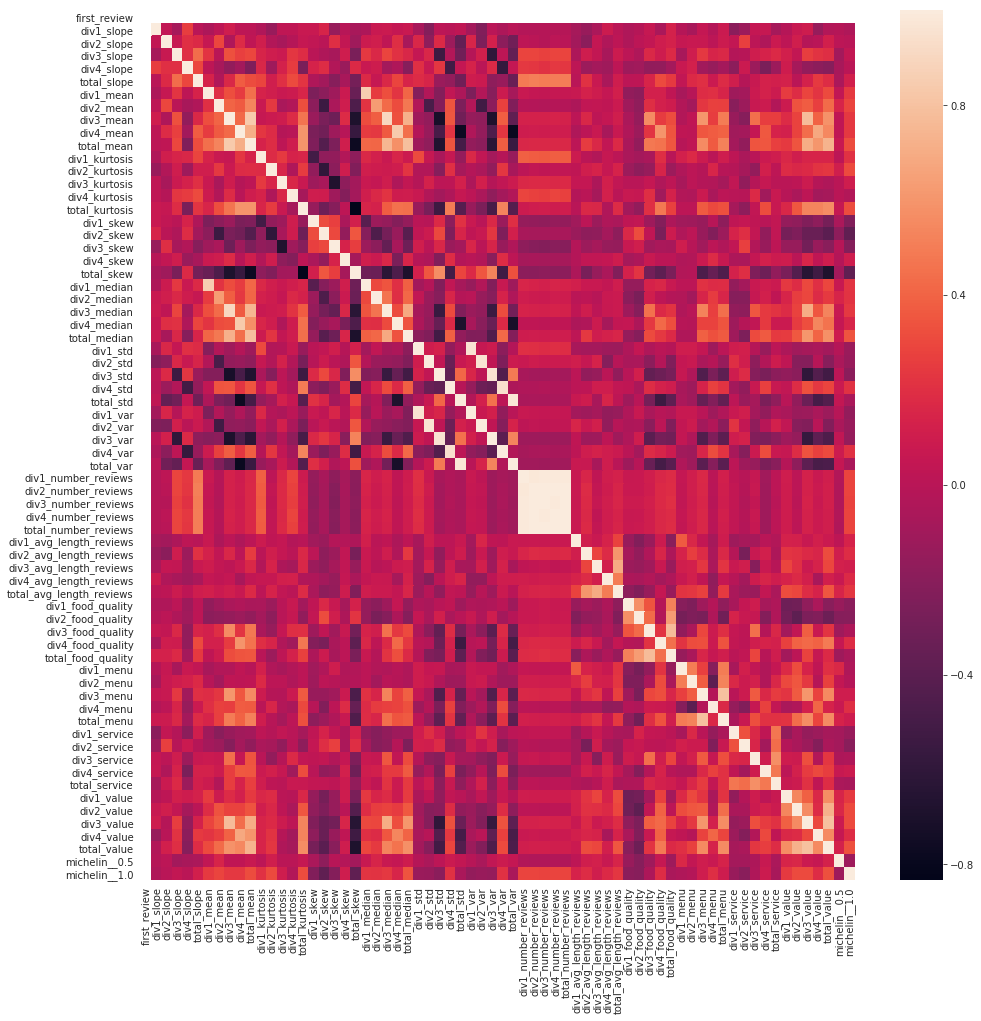

In [42]:
import seaborn as sns
plt.figure(figsize=(16, 16))
corr = train['X'].corr(method = 'pearson')
with sns.axes_style("white"):
    ax = sns.heatmap(corr, vmax=1, square=False)


## Get a baseline model with logsitc regression to evaluate Michelin survival in 2019

Mean Accuracy: 0.88
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.98      0.93        42
           1       0.50      0.17      0.25         6

    accuracy                           0.88        48
   macro avg       0.70      0.57      0.59        48
weighted avg       0.84      0.88      0.85        48

Confusion Matrix: 
 [[41  1]
 [ 5  1]]
0.875


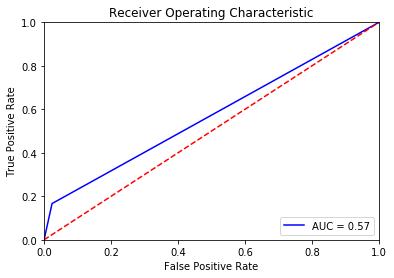

Cross validation score: 0.6128886908298672


In [43]:
clf = LogisticRegression(random_state = 0)
clf = run_model(train, holdout, cols = train['X'].columns.values,  clf = clf)
score = cross_val_score(clf, train['X'], train['y'], cv = 10, scoring= 'roc_auc').mean()
print('Cross validation score: {}'.format(score))

## Resample to balanced classes using SMOTE

Mean Accuracy: 0.76
Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.75      0.76       331
           1       0.75      0.76      0.76       331

    accuracy                           0.76       662
   macro avg       0.76      0.76      0.76       662
weighted avg       0.76      0.76      0.76       662

Confusion Matrix: 
 [[249  82]
 [ 79 252]]
0.756797583081571


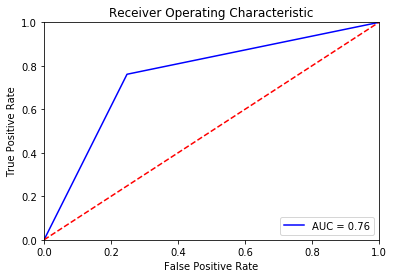

Cross validation score: 0.7489530409473788


In [44]:
resampled_train = {'X' : pd.DataFrame(), 'y': pd.Series()}
resampled_train['X'], resampled_train['y'] = make_resampled(train['X'], train['y'])

clf = LogisticRegression(C = .1, random_state = 0)
clf = run_model(resampled_train, resampled_train, cols = resampled_train['X'].columns,  clf = clf)

score = cross_val_score(clf, resampled_train['X'], resampled_train['y'], cv = 10, scoring= 'roc_auc').mean()
print('Cross validation score: {}'.format(score))


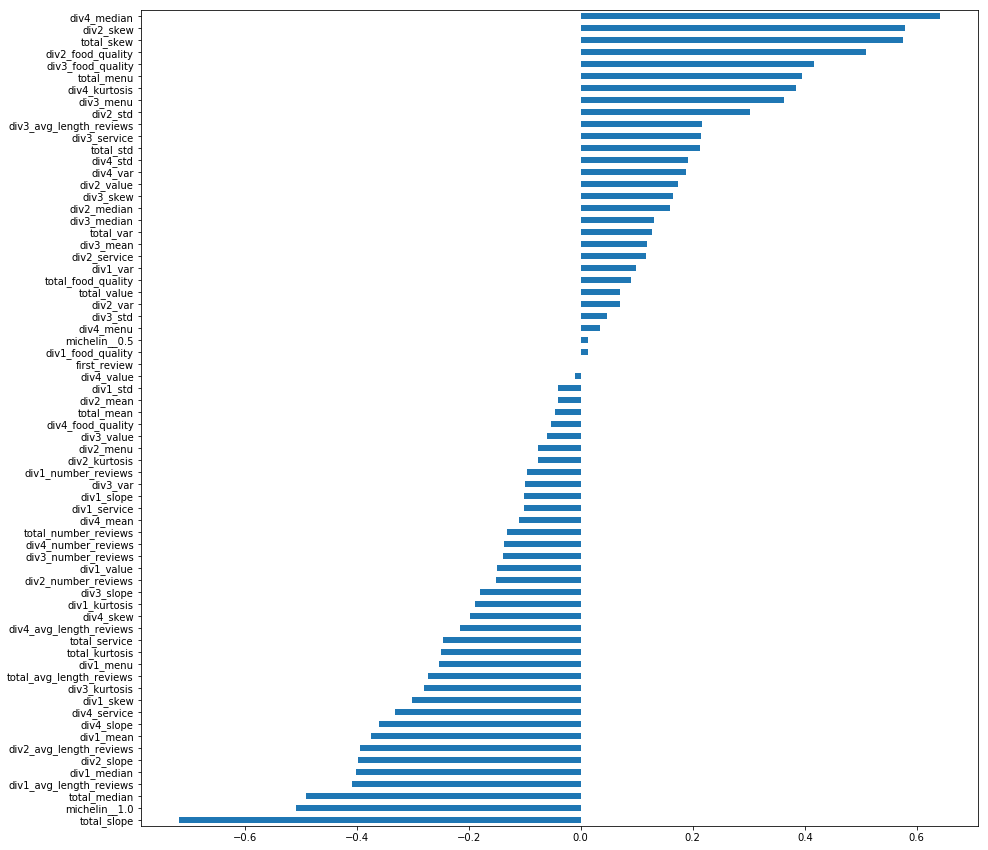

In [45]:
coefs_abs = pd.Series(clf.coef_[0], index = train['X'].columns).sort_values(ascending = True)
coefs_abs.plot.barh(figsize = (15,15))

## Evaluate model on holdout set

Mean Accuracy: 0.65
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.69      0.77        42
           1       0.13      0.33      0.19         6

    accuracy                           0.65        48
   macro avg       0.51      0.51      0.48        48
weighted avg       0.79      0.65      0.70        48

Confusion Matrix: 
 [[29 13]
 [ 4  2]]
0.6458333333333334


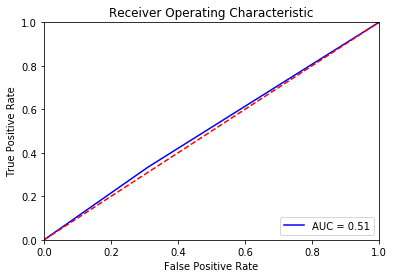

Index(['first_review', 'div1_slope', 'div2_slope', 'div3_slope', 'div4_slope',
       'total_slope', 'div1_mean', 'div2_mean', 'div3_mean', 'div4_mean',
       'total_mean', 'div1_kurtosis', 'div2_kurtosis', 'div3_kurtosis',
       'div4_kurtosis', 'total_kurtosis', 'div1_skew', 'div2_skew',
       'div3_skew', 'div4_skew', 'total_skew', 'div1_median', 'div2_median',
       'div3_median', 'div4_median', 'total_median', 'div1_std', 'div2_std',
       'div3_std', 'div4_std', 'total_std', 'div1_var', 'div2_var', 'div3_var',
       'div4_var', 'total_var', 'div1_number_reviews', 'div2_number_reviews',
       'div3_number_reviews', 'div4_number_reviews', 'total_number_reviews',
       'div1_avg_length_reviews', 'div2_avg_length_reviews',
       'div3_avg_length_reviews', 'div4_avg_length_reviews',
       'total_avg_length_reviews', 'div1_food_quality', 'div2_food_quality',
       'div3_food_quality', 'div4_food_quality', 'total_food_quality',
       'div1_menu', 'div2_menu', 'div3_menu', 'd

In [46]:
clf = LogisticRegression()
clf = run_model(resampled_train, holdout, cols = resampled_train['X'].columns,  clf = clf)
holdout['X'].columns

## Feature elimination

Optimal number of features :50


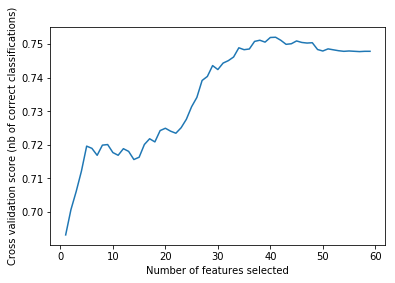

Mean Accuracy: 0.65
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.64      0.76        42
           1       0.21      0.67      0.32         6

    accuracy                           0.65        48
   macro avg       0.57      0.65      0.54        48
weighted avg       0.84      0.65      0.71        48

Confusion Matrix: 
 [[27 15]
 [ 2  4]]
0.6458333333333334


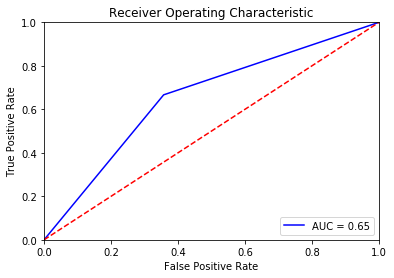

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
clf           = LogisticRegression(C = .1, random_state=0)
selected_cols = get_rfecv_features(resampled_train, clf = LogisticRegression())

run_model(resampled_train, holdout,  clf = clf, cols = selected_cols)

## Evaluate insights for at-risk restaurants for 2020

In [50]:
from sklearn.preprocessing import minmax_scale
predict_year   = 2020
train, holdout = get_train_and_holdout(predict_year, michelin_data, yelp_data)
resampled_train = {'X' : pd.DataFrame(), 'y': pd.Series()}
resampled_train['X'], resampled_train['y'] = make_resampled(train['X'], train['y'])
clf  = LogisticRegression(C = .1, random_state=0)
clf.fit(resampled_train['X'], resampled_train['y'])
clf.predict_proba(holdout['X'])[:1]

probs = -1* minmax_scale(clf.predict_proba(holdout['X'])[:,1], feature_range = (-.99, .99))
probs = pd.Series(probs, index = holdout['X'].index)
df_2020['probs']   = probs 
df_2020['at_risk'] = (df_2020['probs'].apply(np.sign)  + 1)/2

NameError: name 'df_2020' is not defined

In [ ]:
probs = -1* minmax_scale(clf.predict_proba(holdout['X'])[:,1], feature_range = (-.99, .99))
probs = pd.Series(probs, index = holdout['X'].index)
df_2020 = holdout['X'].copy()
df_2020['probs']   = probs 
def risk_thresh(p):
    if p < 0:
        return 1
    else:
        return 0
df_2020['at_risk'] = (df_2020['probs'].apply(risk_thresh))
df_2020.head()
df_2020.to_csv('michelin_2020_model_data.csv')

In [ ]:
at_risk     = probs[probs < 0]
not_at_risk = probs[probs > 0]

main_points = ['total_median', 'total_slope','div4_food_quality', 'div4_menu',  'div4_service', 'div4_value']

In [ ]:
holdout['X'].loc[at_risk.index.values][main_points]

In [133]:
not_at_risk = pd.concat([not_at_risk, holdout['X'].loc[not_at_risk.index.values]], axis = 1)
at_risk     = pd.concat([at_risk, holdout['X'].loc[at_risk.index.values]], axis = 1)

In [162]:
import plotly.graph_objs as go
import plotly.plotly as py

resto    = 'aldea'
times    = ['div1', 'div2', 'div3', 'div4', 'total']
measures = ['mean', 'slope', 'food_quality', 'menu', 'value', 'service']

y = dict()
for time in times:
    for measure in measures:
        dim = '{}_{}'.format(time,measure)
        if measure in y:
            y[measure].append(df_2020.loc[resto][dim])
        else:
            y[measure]= [df_2020.loc[resto][dim]]

trace0 = go.Scatter(
    x = [1,2,3,4],
    y = y['mean'][:4],
    mode = 'lines+markers',
    name = 'mean'
)
trace1 = go.Scatter(
    x = [1,2,3,4],
    y = y['slope'][:4],
    mode = 'lines+markers',
    name = 'slope'
)
trace2 = go.Scatter(
    x =  [1,2,3,4],
    y = y['menu'][:4],
    mode = 'lines+markers',
    name = 'menu_quality'
)

data = [trace0, trace1, trace2]
py.iplot(data, filename='scatter-mode')


/anaconda3/envs/insight/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [160]:
at_risk.columns

Index([                         0,             'first_review',
                     'div1_slope',               'div2_slope',
                     'div3_slope',               'div4_slope',
                    'total_slope',                'div1_mean',
                      'div2_mean',                'div3_mean',
                      'div4_mean',               'total_mean',
                  'div1_kurtosis',            'div2_kurtosis',
                  'div3_kurtosis',            'div4_kurtosis',
                 'total_kurtosis',                'div1_skew',
                      'div2_skew',                'div3_skew',
                      'div4_skew',               'total_skew',
                    'div1_median',              'div2_median',
                    'div3_median',              'div4_median',
                   'total_median',                 'div1_std',
                       'div2_std',                 'div3_std',
                       'div4_std',                'tota

In [153]:
y

{'mean': [0.3755102040816318,
  0.21331151118385172,
  0.5890513685789276,
  0.22234079646672222,
  0.3016025408160088],
 'slope': [0.8113787375415282,
  0.5833392478264959,
  0.7589866771666705,
  0.9336204599553112,
  0.9755570669154453],
 'food_quality': [0.20408163265306123,
  0.37657691583505926,
  0.3724498076570193,
  0.5099562894609034,
  0.4484130118986822],
 'menu': [0.3877551020408163,
  0.970954837961621,
  0.8206047012053905,
  0.029282576866764165,
  0.6260060362173039],
 'value': [0.30612244897959184,
  0.24202127659574468,
  0.28491620111731847,
  0.1894835680751174,
  0.09625424963574551],
 'service': [0.7551020408163265,
  0.6909442588359417,
  0.5011337868480725,
  0.16866278252786096,
  0.3978028963626612]}